In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf

tf.compat.v1.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, save_img

target_image_path = '/content/drive/MyDrive/Colab Notebooks/datasets/portrait.png'
style_reference_image_path='/content/drive/MyDrive/Colab Notebooks/datasets/popova.jpg'

width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [4]:
import numpy as np
from tensorflow.keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [5]:
from tensorflow.keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))
combination_image = K.placeholder((1, img_height, img_width, 3))

input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

model = vgg19.VGG19(input_tensor=input_tensor,
                    weights = 'imagenet',
                    include_top=False)
print('모델 로드 완료.')

80150528/80134624 [==============================] - 1s 0us/step
모델 로드 완료.


In [6]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [7]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [8]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] -
        x[:, :1, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] -
        x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [9]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = 'block5_conv2'
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']
total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(style_layers)) * sl

loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [10]:
grads = K.gradients(loss, combination_image)[0]

fetch_loss_and_grads = K.function([combination_image], [loss, grads])

class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grads_value = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [11]:
from scipy.optimize import fmin_l_bfgs_b
import time

result_prefix = 'style_transfer_result'
iterations = 20

x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('반복 횟수:', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x, fprime=evaluator.grads, maxfun=20)

    print('현재 손실 값:', min_val)
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    save_img(fname, img)
    end_time = time.time()
    print('저장 이미지: ', fname)
    print('%d 번째 반복 완료: %ds' % (i, end_time - start_time))

반복 횟수: 0
현재 손실 값: 8025812000.0
저장 이미지:  style_transfer_result_at_iteration_0.png
0 번째 반복 완료: 48s
반복 횟수: 1
현재 손실 값: 3245387500.0
저장 이미지:  style_transfer_result_at_iteration_1.png
1 번째 반복 완료: 13s
반복 횟수: 2
현재 손실 값: 2101948300.0
저장 이미지:  style_transfer_result_at_iteration_2.png
2 번째 반복 완료: 13s
반복 횟수: 3
현재 손실 값: 1644870900.0
저장 이미지:  style_transfer_result_at_iteration_3.png
3 번째 반복 완료: 13s
반복 횟수: 4
현재 손실 값: 1348752600.0
저장 이미지:  style_transfer_result_at_iteration_4.png
4 번째 반복 완료: 13s
반복 횟수: 5
현재 손실 값: 1172070000.0
저장 이미지:  style_transfer_result_at_iteration_5.png
5 번째 반복 완료: 13s
반복 횟수: 6
현재 손실 값: 1033179200.0
저장 이미지:  style_transfer_result_at_iteration_6.png
6 번째 반복 완료: 13s
반복 횟수: 7
현재 손실 값: 929392800.0
저장 이미지:  style_transfer_result_at_iteration_7.png
7 번째 반복 완료: 13s
반복 횟수: 8
현재 손실 값: 859017540.0
저장 이미지:  style_transfer_result_at_iteration_8.png
8 번째 반복 완료: 13s
반복 횟수: 9
현재 손실 값: 803995100.0
저장 이미지:  style_transfer_result_at_iteration_9.png
9 번째 반복 완료: 13s
반복 횟수: 10
현재 손실 값: 754398000.0
저장

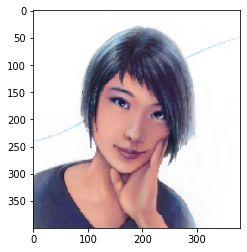

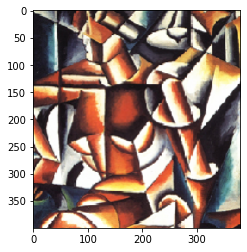

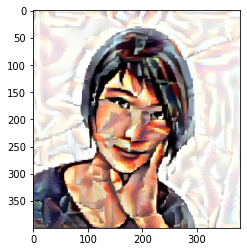

In [12]:
from matplotlib import pyplot as plt

plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

plt.imshow(img)
plt.show()